In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import KFold
from pygam import LinearGAM, s
import matplotlib.pyplot as plt

In [3]:
all_data = pd.read_csv("/home/al.pedro.alberti/Downloads/all_data.csv")

data_treino = all_data[all_data['MonthlyIncome'].notna()]
data_teste = all_data[all_data['MonthlyIncome'].isna()]

na_count = pd.DataFrame({
    "Dataset de Treino": data_treino.isna().sum(),
    "Dataset de Teste": data_teste.isna().sum()
})

na_count

,Dataset de Treino,Dataset de Teste
SeriousDlqin2yrs,0,0
RevolvingUtilizationOfUnsecuredLines,0,0
age,0,0
NumberOfTime30-59DaysPastDueNotWorse,0,0
DebtRatio,0,0
MonthlyIncome,0,43284
NumberOfOpenCreditLinesAndLoans,0,0
NumberOfTimes90DaysLate,0,0
NumberRealEstateLoansOrLines,0,0
NumberOfTime60-89DaysPastDueNotWorse,0,0


Fazer o cross-validation para achar o melhor valor de lambda da GAM

Best lambda: 1


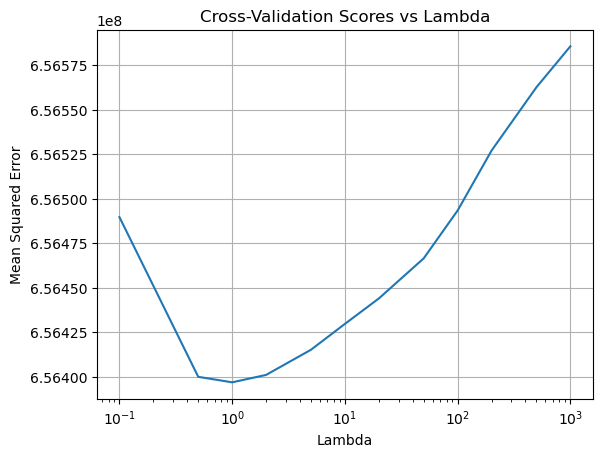

In [ ]:
#preparar os dados
X = data_treino.drop('MonthlyIncome', axis=1) 
y = data_treino['MonthlyIncome']

# definir a lista de valores de lambda para testar
lam_list = [0.1,0.5, 1,2, 5, 10, 20, 50, 100, 200, 500, 1000]

# inicializar KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# guardar os scores de cross validation
cv_scores = []

# fazer cross-validation para cada valor de lambda
for lam in lam_list:
    fold_scores = []
    #separação dos dados em folds
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # fazer a GAM com o valor atual de lambda
        gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), lam=lam).fit(X_train, y_train)
        
        # calcular o MSE no fold de validação
        y_pred = gam.predict(X_val)
        mse = np.mean((y_val - y_pred)**2)
        fold_scores.append(mse)
    
    cv_scores.append(np.mean(fold_scores))

# Find best lambda
best_lam = lam_list[np.argmin(cv_scores)]
print('Best lambda: ', best_lam)

# Plot CV scores
plt.semilogx(lam_list, cv_scores)
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation Scores vs Lambda')
plt.grid(True)

O melhor valor de lamba é 1. Agora farei a GAM com este valor de lambda.

In [11]:
#treinar o modelo usando o melhor lambda encontrado
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), lam=best_lam).fit(X, y)

#predizer os valores faltantes 
y_pred = gam.predict(data_teste.drop('MonthlyIncome', axis=1))

#criar o dataset final com as previsões
data_teste_with_predictions = data_teste.copy()
data_teste_with_predictions['MonthlyIncome'] = y_pred
data_teste_with_predictions.to_csv("/home/al.pedro.alberti/Downloads/data_teste_with_predictions.csv", index=False)

# Create new all_data without missing values by concatenating training and test data
all_data_complete = pd.concat([data_treino, data_teste_with_predictions])
all_data_complete.to_csv("/home/al.pedro.alberti/Downloads/all_data_complete.csv", index=False)

#verificar se ainda há valores faltantes
na_count = pd.DataFrame({
    "Dataset de Treino": data_treino.isna().sum(),
    "Dataset de Teste": data_teste.isna().sum(),
    'dataset final': data_teste_with_predictions.isna().sum()
})

na_count

,Dataset de Treino,Dataset de Teste,dataset final
SeriousDlqin2yrs,0,0,0
RevolvingUtilizationOfUnsecuredLines,0,0,0
age,0,0,0
NumberOfTime30-59DaysPastDueNotWorse,0,0,0
DebtRatio,0,0,0
MonthlyIncome,0,43284,0
NumberOfOpenCreditLinesAndLoans,0,0,0
NumberOfTimes90DaysLate,0,0,0
NumberRealEstateLoansOrLines,0,0,0
NumberOfTime60-89DaysPastDueNotWorse,0,0,0


O problema que queriamos resolver de fato foi resolvido

In [16]:
data_teste = all_data_complete[(all_data_complete['SeriousDlqin2yrs'] == 1) | (all_data_complete['SeriousDlqin2yrs'] == 0)]
data_treino = all_data_complete[(all_data_complete['SeriousDlqin2yrs'] != 1) & (all_data_complete['SeriousDlqin2yrs'] != 0)]

data_teste.to_csv("/home/al.pedro.alberti/Downloads/data_teste.csv", index=False)
data_treino.to_csv("/home/al.pedro.alberti/Downloads/data_treino.csv", index=False)

Separação dos novos dados totais em treino e teste